In [1]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
#This is so that the plots are there along with the code in the notebook rather than a popup
%matplotlib inline

import os
from os.path import isfile,join
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torchvision.transforms as T
from torch.nn.modules import padding
from scipy.ndimage import distance_transform_edt
from monai.metrics import HausdorffDistanceMetric,SurfaceDistanceMetric
import math
import sys

In [3]:
# For reproducing results
seed = 42
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

## Getting Data

In [5]:
# GPU | CPU
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')

def to_device(data,device):
    
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    
    return data.to(device,non_blocking = True)

In [6]:
''' ----------------------------------------------------------
    All the content here is intermediate data used to obtain df
    None of these will be referenced later in the notebook 
    ---------------------------------------------------------- '''

base_path = "../processed/"
#"/content/drive/MyDrive/AI Club Project - Segmentation/processed/"

file_names = {"image": "img_crp_v2.npy", 
              "esophagus": "/structure/Esophagus_crp_v2.npy",
              "heart": "/structure/Heart_crp_v2.npy",
              "lung_L": "/structure/Lung_L_crp_v2.npy",
              "lung_R": "/structure/Lung_R_crp_v2.npy",
              "spinal_cord": "/structure/SpinalCord_crp_v2.npy"} 

dirs = [(base_path + f + "/") for f in os.listdir(base_path) if not isfile(join(base_path,f))]

data = [[f + file_names["image"],
         f + file_names["esophagus"],
         f + file_names["heart"],
         f + file_names["lung_L"],
         f + file_names["lung_R"],
         f + file_names["spinal_cord"]] for f in dirs]


In [7]:
#df contains all data regarding input data
df = pd.DataFrame(data, columns = ['Image','Esophagus','Heart','Lung_L','Lung_R','SpinalCord'])
df.head()

,Image,Esophagus,Heart,Lung_L,Lung_R,SpinalCord
0,../processed/LCTSC-Train-S3-005/img_crp_v2.npy,../processed/LCTSC-Train-S3-005//structure/Eso...,../processed/LCTSC-Train-S3-005//structure/Hea...,../processed/LCTSC-Train-S3-005//structure/Lun...,../processed/LCTSC-Train-S3-005//structure/Lun...,../processed/LCTSC-Train-S3-005//structure/Spi...
1,../processed/LCTSC-Train-S1-004/img_crp_v2.npy,../processed/LCTSC-Train-S1-004//structure/Eso...,../processed/LCTSC-Train-S1-004//structure/Hea...,../processed/LCTSC-Train-S1-004//structure/Lun...,../processed/LCTSC-Train-S1-004//structure/Lun...,../processed/LCTSC-Train-S1-004//structure/Spi...
2,../processed/LCTSC-Train-S2-004/img_crp_v2.npy,../processed/LCTSC-Train-S2-004//structure/Eso...,../processed/LCTSC-Train-S2-004//structure/Hea...,../processed/LCTSC-Train-S2-004//structure/Lun...,../processed/LCTSC-Train-S2-004//structure/Lun...,../processed/LCTSC-Train-S2-004//structure/Spi...
3,../processed/LCTSC-Train-S3-008/img_crp_v2.npy,../processed/LCTSC-Train-S3-008//structure/Eso...,../processed/LCTSC-Train-S3-008//structure/Hea...,../processed/LCTSC-Train-S3-008//structure/Lun...,../processed/LCTSC-Train-S3-008//structure/Lun...,../processed/LCTSC-Train-S3-008//structure/Spi...
4,../processed/LCTSC-Train-S3-012/img_crp_v2.npy,../processed/LCTSC-Train-S3-012//structure/Eso...,../processed/LCTSC-Train-S3-012//structure/Hea...,../processed/LCTSC-Train-S3-012//structure/Lun...,../processed/LCTSC-Train-S3-012//structure/Lun...,../processed/LCTSC-Train-S3-012//structure/Spi...


## Datagen

In [8]:
def Datagen_CT(df,img_size,seg_organ,window_size):

    for _, row in df.iterrows():

        image = np.load(row["Image"])
        image = np.moveaxis(image,0,-1)
        image = cv2.resize(image, (img_size,img_size))
        image = np.swapaxes(image,0,-1)

        mask = np.load(row[seg_organ])
        mask = np.moveaxis(mask,0,-1)
        mask = cv2.resize(mask , (img_size,img_size))
        mask = np.swapaxes(mask,0,-1)

        #Padding to fit window_size
        image = np.concatenate((np.zeros((int(window_size/2),img_size,img_size)),image))
        image = np.concatenate((image,np.zeros((int(window_size),img_size,img_size)))) #This is to ensure that the last valid slice can be reached
        mask = np.concatenate((np.zeros((int(window_size/2),img_size,img_size)),mask))
        mask = np.concatenate((mask,np.zeros((int(window_size/2),img_size,img_size))))

        half_window = window_size//2
        slice_index = half_window + 1 #the index of the next slice to be examined

        while slice_index + window_size + half_window - 1 <= mask.shape[0]:#we put mask here because image has a longer size to adjust for the last slice
            images = image[slice_index - half_window : slice_index + window_size + half_window,:,:]
            masks = mask[slice_index: slice_index + window_size,:,:]

            slice_index = slice_index + window_size
            images = np.expand_dims(images,axis=1).astype('float32')
            masks = np.expand_dims(masks,axis=1).astype('float32')

            yield images, masks


## Model

In [9]:
class AttentionGate(nn.Module):
    
    def __init__(self,F_g,F_x,F_int,pool_size):
        super(AttentionGate,self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True)
        self.W_x = nn.Conv2d(F_x,F_int,kernel_size=1,stride=1,padding=0,bias=True)
        self.psi = nn.Conv2d(F_int,1,kernel_size=1,stride=1,padding=0,bias=True)
        self.pool_size = pool_size
        self.maxpool = nn.MaxPool2d((self.pool_size,self.pool_size))
        
        self.batchnorm_g = nn.BatchNorm2d(F_int)
        self.batchnorm_x = nn.BatchNorm2d(F_int)
    
    def forward(self,g,x): #g : lower layer and x : corresponding encoder img
        g1 = self.W_g(g)
        g1 = self.batchnorm_g(g1)
        
        x1 = self.W_x(x)
        x1 = self.batchnorm_x(x1)
        x1 = self.maxpool(x1)
        
        interim = F.relu(g1+x1)
        psi = self.psi(interim)
        psi = torch.sigmoid(psi)
        
        psi = F.interpolate(psi,scale_factor=(self.pool_size,self.pool_size),mode='bilinear',align_corners=True)
        return x * psi

In [10]:
class EncoderBlock(nn.Module):
    
    def __init__(self,dim_i,dim_o):
        super(EncoderBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(dim_i,dim_o,3,padding="same")
        self.batchnorm1 = nn.BatchNorm2d(dim_o)
        self.conv2 = nn.Conv2d(dim_o,dim_o,3,padding="same")
        self.batchnorm2 = nn.BatchNorm2d(dim_o)
        
    def forward(self,x):
        
        x1 = self.conv1(x)
        x1 = F.leaky_relu(x1)
        x1 = self.batchnorm1(x1)
        x1 = self.conv2(x1)
        x1 = F.leaky_relu(x1)
        x1 = self.batchnorm2(x1)
        return x1

class UNet_Encoder(nn.Module):
    
    def __init__(self):
        super(UNet_Encoder,self).__init__()

        self.enc1 = EncoderBlock(1,32)
        self.enc2 = EncoderBlock(32,64)
        self.enc3 = EncoderBlock(64,128)
        self.enc4 = EncoderBlock(128,256)
        self.enc5 = EncoderBlock(256,512)
        self.enc6 = EncoderBlock(512,1024)
        
        self.strided_conv1 = nn.Conv2d(32,32,kernel_size=4,stride=4)
        self.strided_conv2 = nn.Conv2d(64,64,kernel_size=4,stride=4)
        self.strided_conv3 = nn.Conv2d(128,128,kernel_size=4,stride=4)
        self.strided_conv4 = nn.Conv2d(256,256,kernel_size=2,stride=2)
        self.strided_conv5 = nn.Conv2d(512,512,kernel_size=2,stride=2)
    
    def forward(self,x):

        x1 = self.enc1(x)
        
        x2 = self.strided_conv1(x1)
        x2 = F.leaky_relu(x2)
        x2 = self.enc2(x2)
        
        x3 = self.strided_conv2(x2)
        x3 = F.leaky_relu(x3)
        x3 = self.enc3(x3)

        x4 = self.strided_conv3(x3)
        x4 = F.leaky_relu(x4)
        x4 = self.enc4(x4)

        x5 = self.strided_conv4(x4)
        x5 = F.leaky_relu(x5)
        x5 = self.enc5(x5)

        x6 = self.strided_conv5(x5)
        x6 = F.leaky_relu(x6)
        x6 = self.enc6(x6)
        
        return (x1,x2,x3,x4,x5,x6)

In [11]:
class DecoderBlock(nn.Module):
    
    def __init__(self,dim_i,dim_o,up_size):
        super(DecoderBlock,self).__init__()
        
        self.trans_conv = nn.ConvTranspose2d(dim_i,dim_o,kernel_size=up_size,stride=up_size)
        self.attn_gate = AttentionGate(F_g=dim_i,F_x=dim_o,F_int=dim_o,pool_size=up_size)
        
        self.conv_r1 = nn.Conv2d(dim_i,dim_o,kernel_size=3,padding="same")
        self.conv_r2 = nn.Conv2d(dim_o,dim_o,kernel_size=3,padding="same")
        
        self.batchnorm_r1 = nn.BatchNorm2d(dim_o)
        self.batchnorm_r2 = nn.BatchNorm2d(dim_o)
        
    def forward(self,x,x_enc):
        xi = self.trans_conv(x)
        xa = self.attn_gate(x,x_enc)
        xi = torch.cat((xi,xa),dim=1) #concatenating to the channel dimension
        
        xi = self.conv_r1(xi)
        xi = F.leaky_relu(xi)
        xi = self.batchnorm_r1(xi)
        
        xi = self.conv_r2(xi)
        xi = F.leaky_relu(xi)
        xi = self.batchnorm_r2(xi)
        
        return xi
        


class UNet_Decoder(nn.Module):
    
    def __init__(self):
        super(UNet_Decoder,self).__init__()
        
        #since last two maxpools are x4, the filter and strides of first two transpose convs are 4 each
        self.dec1 = DecoderBlock(1024,512,2)
        self.dec2 = DecoderBlock(512,256,2)
        self.dec3 = DecoderBlock(256,128,4)
        self.dec4 = DecoderBlock(128,64,4)
        self.dec5 = DecoderBlock(64,32,4)

    
    def forward(self,x1,x2,x3,x4,x5,x_attn,window_size): 
        
        x_attn = x_attn[(window_size//2):-(window_size//2)] #<----- REMOVE WHEN ATTENTION IS INTRODUCED
        xi = self.dec1(x_attn,x5[(window_size//2):-(window_size//2)])
        xi = self.dec2(xi,x4[(window_size//2):-(window_size//2)])
        xi = self.dec3(xi,x3[(window_size//2):-(window_size//2)])
        xi = self.dec4(xi,x2[(window_size//2):-(window_size//2)])
        xi = self.dec5(xi,x1[(window_size//2):-(window_size//2)])
        
        return xi

In [12]:
#Input size is (window_size, 1, 512, 512)
class UNet(nn.Module):

    def __init__(self,encoder,decoder):
        super(UNet,self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.conv_f = nn.Conv2d(32,1,kernel_size=1)

    def forward(self,x,window_size): #note: the entire batch is passed in 

        #Encoder
        x1,x2,x3,x4,x5,x6 = self.encoder(x)

        #Decoder
        xi_1 = self.decoder(x1,x2,x3,x4,x5,x6,window_size)

        #Final
        xf = self.conv_f(xi_1)
        xf = torch.sigmoid(xf)
        return xf

## Loss Function

In [13]:
def log_dice_loss(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)
    
    intersection = torch.sum(y_true_f * y_pred_f,1)
    result = torch.log((2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth))
    dice_loss = -1 * torch.sum(result)/y_pred.shape[0]
    return  dice_loss

def dice_loss(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)
    
    intersection = torch.sum(y_true_f * y_pred_f,1)
    result = (2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth)
    dice_loss = torch.sum(1-result)/y_pred.shape[0]
    return  dice_loss

def focal_loss(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)

#     #dice metric
#     intersection = torch.sum(y_true_f * y_pred_f,1)
#     result = (2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth)
#     dice_loss = -1 * torch.sum(torch.log(result))

    #focal loss
    gamma = 2
    alpha = 0.25

    bce_loss = F.binary_cross_entropy_with_logits(y_pred_f,y_true_f,reduction='none')
    pt = torch.exp(-1 * bce_loss)

    temp_at = to_device(torch.tensor([alpha,1-alpha]),get_default_device())
    y_true_f = y_true_f.type(torch.long)
    at = ((1-alpha) * (1 - y_true_f)) + (alpha * y_true_f)

    F_loss = torch.sum(at * ((1-pt) ** gamma) * bce_loss)

    return  (F_loss) / y_pred.shape[0]

## Eval Metrics

In [48]:
#IOU [Between 0-1: Higher value => Better results]
def iou_metric(y_pred,y_true):
    y_true_f = torch.flatten(y_true,start_dim=1).detach().cpu()
    y_pred_f = torch.flatten(y_pred,start_dim=1).detach().cpu()
    
    y_pred_f[y_pred_f >= 0.5] = 1
    y_pred_f[y_pred_f < 0.5] = 0

    intersection = torch.sum(y_true_f * y_pred_f,1)
    union = torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) - torch.sum(y_true_f * y_pred_f,1)
    
    iou_score = 0
    for i in range(union.shape[0]):
        if union[i] == 0:
            iou_score += 1
        else:
            iou_score += intersection[i].item()/union[i].item()
    iou_score = iou_score/y_pred.shape[0]
    return iou_score

#Dice [Between 0-1: Higher value => Better results]
def dice_metric(y_pred,y_true):
    y_true_f = torch.flatten(y_true,start_dim=1).detach().cpu()
    y_pred_f = torch.flatten(y_pred,start_dim=1).detach().cpu()
    
    y_pred_f[y_pred_f >= 0.5] = 1
    y_pred_f[y_pred_f < 0.5] = 0

    intersection = torch.sum(y_true_f * y_pred_f,1)
    area_sum = torch.sum(y_true_f,1) + torch.sum(y_pred_f,1)
    
    dice_score = 0
    for i in range(area_sum.shape[0]):
        if area_sum[i] == 0:
            dice_score += 1
        else:
            dice_score += 2. * intersection[i].item() / area_sum[i].item()
    dice_score = dice_score/y_pred.shape[0]
    return  dice_score

#Precision [Between 0-1: Larger value => Better results]
def precision_metric(y_pred,y_true):
    y_true = torch.flatten(y_true,start_dim=1).detach().cpu()
    y_pred = torch.flatten(y_pred,start_dim=1).detach().cpu()

    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    tp = torch.sum(y_pred * y_true,1)
    denom = torch.sum(y_pred,1)
    true_sum = torch.sum(y_true,1)
    
    pre = 0
    for i in range(denom.shape[0]):
        if denom[i] == 0 and true_sum[i] == 0:
            pre += 1
        elif denom[i] == 0:
            continue
        else:
            pre += tp[i].item()/denom[i].item()
    pre_score = pre/y_pred.shape[0]
    return pre_score

#Recall [Between 0-1: Larger value => Better results]
def recall_metric(y_pred,y_true):
    y_true = torch.flatten(y_true,start_dim=1).detach().cpu()
    y_pred = torch.flatten(y_pred,start_dim=1).detach().cpu()

    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    tp = torch.sum(y_pred * y_true,1)
    denom = torch.sum(y_true,1)
    
    re = 0
    for i in range(denom.shape[0]):
        if denom[i] == 0:
            re += 1
        else:
            re += tp[i].item()/denom[i].item()
    re_score = re/y_pred.shape[0]
    return re_score

## Eval Function

In [28]:
def eval(model,test_df,img_size,seg_organ,window_size,epoch=0,epochs=0):
    #epoch and epoch size is passed if this function is called during training in between epochs
    model.eval()
    test_dataloader = Datagen_CT(df=test_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size)

    iou_val = 0
    dice_val = 0
    pre_val = 0
    re_val = 0

    count = 0
    for batch_idx, (X,y) in enumerate(test_dataloader):
        X = to_device(torch.tensor(X, requires_grad=True),get_default_device())
        y = to_device(torch.tensor(y, requires_grad=True),get_default_device())

        output = model(X,window_size)
        iou_val += iou_metric(output,y)
        dice_val += dice_metric(output,y)
        pre_val += precision_metric(output,y)
        re_val += recall_metric(output,y)

        count = count + 1
        
    dice_score = dice_val/count
    iou_score = iou_val/count
    pre_score = pre_val/count
    re_score = re_val/count
    
    
    
    print('End of Epoch [{}/{}]   Dice Metric: {:.4f}  IoU Metric: {:.4f}  Precision Metric: {:.4f}  Recall Metric: {:.4f}'.format(epoch+1,epochs,dice_score,iou_score,pre_score,re_score))

    

## Fit Function

In [52]:
def fit(model,img_size,seg_organ,window_size,loss_fn,optimizer,scheduler,epochs,train_df,test_df,validate=False,print_every=1):


    for epoch in range(epochs):

        model.train()
        train_dataloader = Datagen_CT(df=train_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size)
        
        total_loss = 0
        max_out = 0
        for batch_idx, (X,y) in enumerate(train_dataloader):
            X = to_device(torch.tensor(X, requires_grad=True),get_default_device())
            y = to_device(torch.tensor(y, requires_grad=True),get_default_device())

            optimizer.zero_grad()
            output = model(X,window_size)
            loss = loss_fn(output,y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            max_out = max(max_out,torch.max(output))

            if batch_idx != 0 and batch_idx % print_every == 0:
                print('Epoch [{}/{}]   Batch {}   Loss: {:.4f}    Max: {:.4f}'.format(epoch+1,epochs,batch_idx,total_loss/print_every,max_out))
                total_loss = 0
                max_out = 0
        

                plt.subplot(1,3,1)
                plt.imshow(X.cpu().detach().numpy()[window_size//2][0])

                plt.subplot(1,3,2)
                plt.imshow(y.cpu().detach().numpy()[0][0])

                plt.subplot(1,3,3)
                plt.imshow(output.cpu().detach().numpy()[0][0])

                plt.show()


#         print('Epoch [{}/{}]   Batch {}   Loss: {:.4f}    lr: {:.10f}'.format(epoch+1,epochs,batch_idx,loss.item(),optimizer.param_groups[0]['lr']))
#         print('\n')
        scheduler.step()

        if validate:
            eval(model=model,test_df=test_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size,epoch=epoch,epochs=epochs)
            


## Training

In [17]:
#Parameters
img_size = 512
epochs = 100
seg_organ = 'Lung_L'
train_test_split = 0.8
window_size = 5

#Dataset Specific
train_df = df[:int(train_test_split*df.shape[0])].reset_index(drop=True)
test_df = df[int(train_test_split*df.shape[0]):].reset_index(drop=True)

In [43]:
#Model Specific
enc = UNet_Encoder()
dec = UNet_Decoder()
model = UNet(enc,dec)
model = to_device(model,get_default_device())

In [19]:
# model.load_state_dict(torch.load('Adv_MSA_wAG_Model/v1'))
#'/content/drive/MyDrive/AI Club Project - Segmentation/UNet - Models/Single Slice Models/adv_sma_wag_lung_l_100epochs'

<All keys matched successfully>

In [44]:
#Training Specific
loss_fn = dice_loss

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1)#7#11

Starting LR:  0.01


Epoch [1/100]   Batch 100   Loss: 0.6020    Max: 0.0000


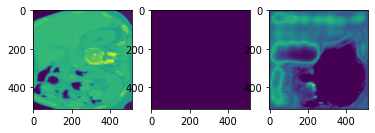

Epoch [1/100]   Batch 200   Loss: 0.5100    Max: 0.0000


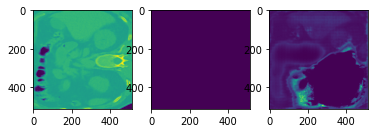

Epoch [1/100]   Batch 300   Loss: 0.7559    Max: 0.0000


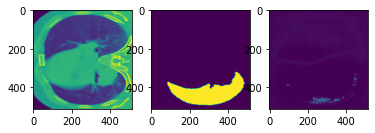

Epoch [1/100]   Batch 400   Loss: 0.7399    Max: 0.0000


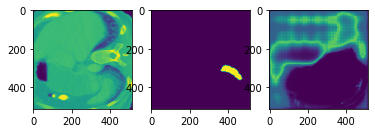

Epoch [1/100]   Batch 500   Loss: 0.6939    Max: 0.0000


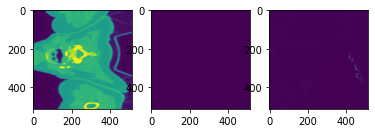

Epoch [1/100]   Batch 600   Loss: 0.6440    Max: 0.0000


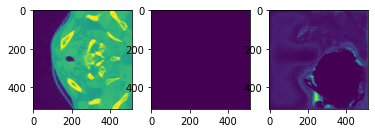

Epoch [1/100]   Batch 700   Loss: 0.6020    Max: 0.0000


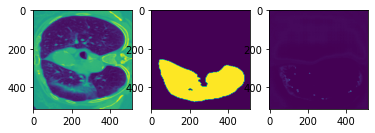

Epoch [1/100]   Batch 800   Loss: 0.7019    Max: 0.0000


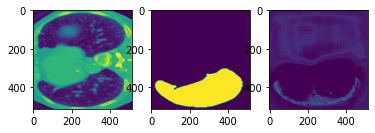

Epoch [1/100]   Batch 900   Loss: 0.6059    Max: 0.0000


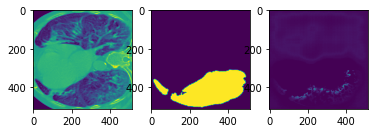

Epoch [1/100]   Batch 1000   Loss: 0.6839    Max: 0.0000


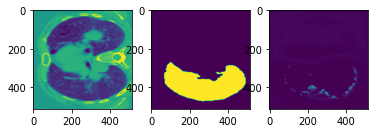

Epoch [1/100]   Batch 1100   Loss: 0.6519    Max: 0.0000


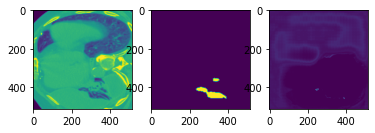

Epoch [1/100]   Batch 1200   Loss: 0.7278    Max: 0.0000


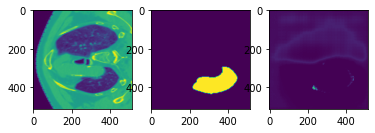

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


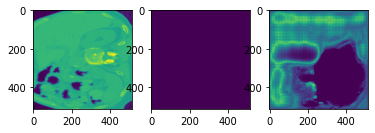

Epoch [2/100]   Batch 200   Loss: 0.5100    Max: 0.0000


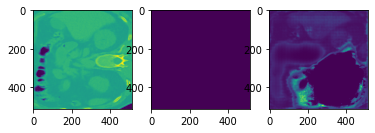

Epoch [2/100]   Batch 300   Loss: 0.7559    Max: 0.0000


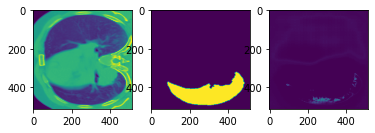

Epoch [2/100]   Batch 400   Loss: 0.7399    Max: 0.0000


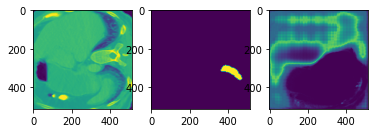

Epoch [2/100]   Batch 500   Loss: 0.6939    Max: 0.0000


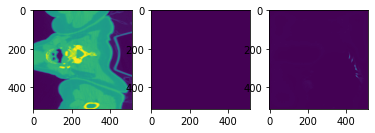

Epoch [2/100]   Batch 600   Loss: 0.6440    Max: 0.0000


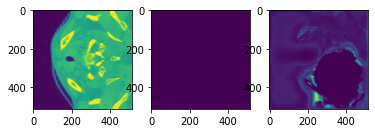

Epoch [2/100]   Batch 700   Loss: 0.6020    Max: 0.0000


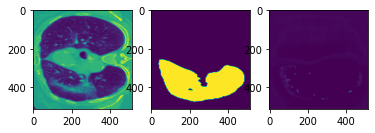

Epoch [2/100]   Batch 800   Loss: 0.7019    Max: 0.0000


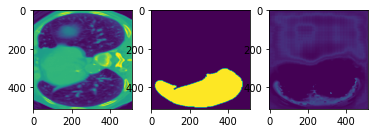

Epoch [2/100]   Batch 900   Loss: 0.6059    Max: 0.0000


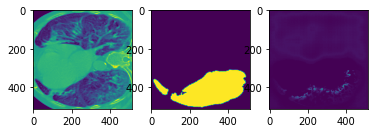

Epoch [2/100]   Batch 1000   Loss: 0.6839    Max: 0.0000


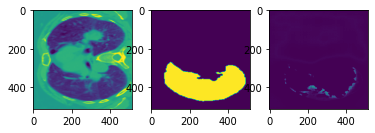

Epoch [2/100]   Batch 1100   Loss: 0.6519    Max: 0.0000


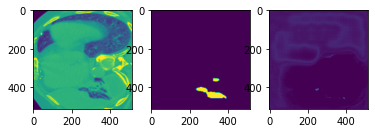

Epoch [2/100]   Batch 1200   Loss: 0.7278    Max: 0.0000


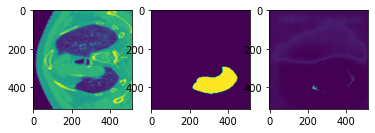

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


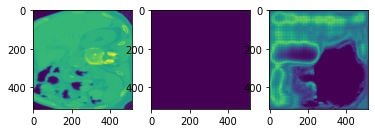

Epoch [3/100]   Batch 200   Loss: 0.5100    Max: 0.0000


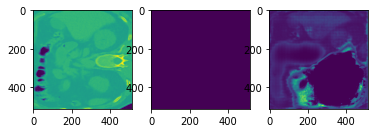

Epoch [3/100]   Batch 300   Loss: 0.7559    Max: 0.0000


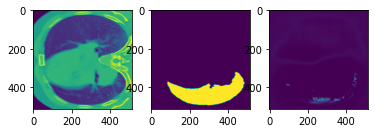

Epoch [3/100]   Batch 400   Loss: 0.7399    Max: 0.0000


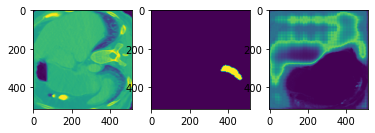

Epoch [3/100]   Batch 500   Loss: 0.6939    Max: 0.0000


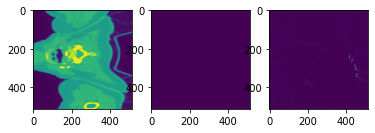

Epoch [3/100]   Batch 600   Loss: 0.6439    Max: 0.0000


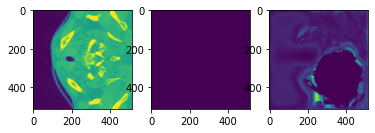

Epoch [3/100]   Batch 700   Loss: 0.6019    Max: 0.0000


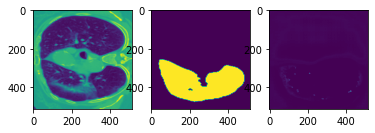

Epoch [3/100]   Batch 800   Loss: 0.7019    Max: 0.0000


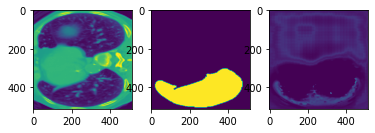

Epoch [3/100]   Batch 900   Loss: 0.6059    Max: 0.0000


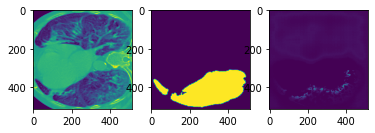

Epoch [3/100]   Batch 1000   Loss: 0.6839    Max: 0.0000


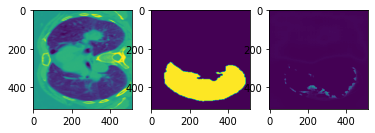

Epoch [3/100]   Batch 1100   Loss: 0.6519    Max: 0.0000


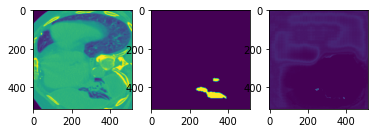

Epoch [3/100]   Batch 1200   Loss: 0.7278    Max: 0.0000


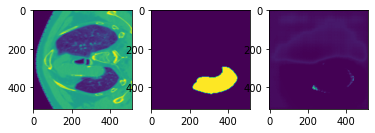

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


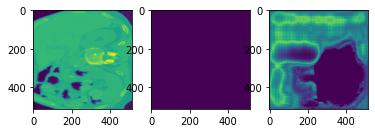

Epoch [4/100]   Batch 200   Loss: 0.5099    Max: 0.0000


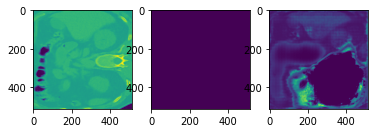

Epoch [4/100]   Batch 300   Loss: 0.7559    Max: 0.0000


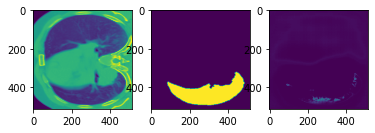

Epoch [4/100]   Batch 400   Loss: 0.7399    Max: 0.0000


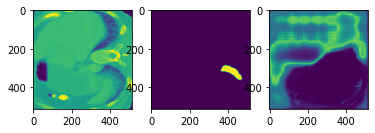

Epoch [4/100]   Batch 500   Loss: 0.6939    Max: 0.0000


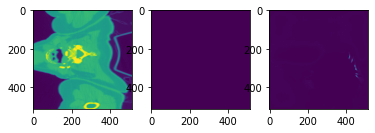

Epoch [4/100]   Batch 600   Loss: 0.6439    Max: 0.0000


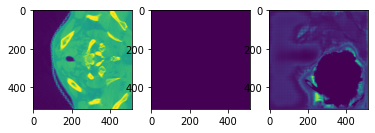

Epoch [4/100]   Batch 700   Loss: 0.6019    Max: 0.0000


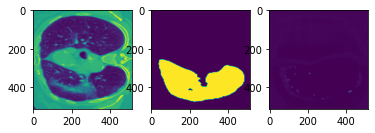

Epoch [4/100]   Batch 800   Loss: 0.7019    Max: 0.0000


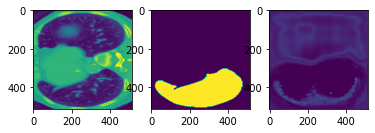

Epoch [4/100]   Batch 900   Loss: 0.6059    Max: 0.0000


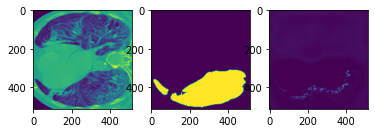

Epoch [4/100]   Batch 1000   Loss: 0.6839    Max: 0.0000


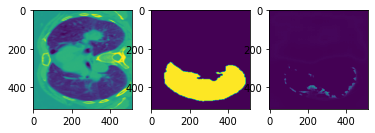

Epoch [4/100]   Batch 1100   Loss: 0.6519    Max: 0.0000


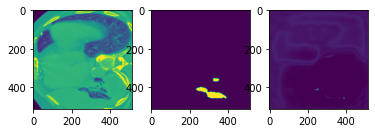

Epoch [4/100]   Batch 1200   Loss: 0.7278    Max: 0.0000


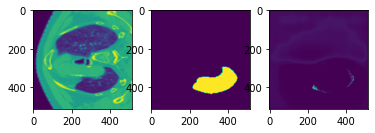

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


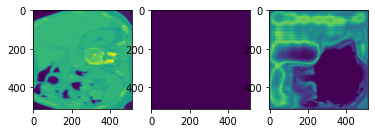

Epoch [5/100]   Batch 200   Loss: 0.5099    Max: 0.0000


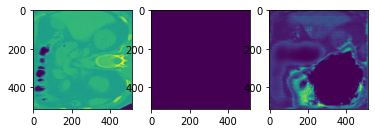

Epoch [5/100]   Batch 300   Loss: 0.7559    Max: 0.0000


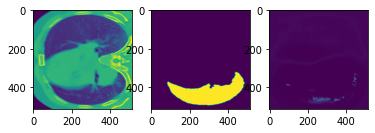

Epoch [5/100]   Batch 400   Loss: 0.7399    Max: 0.0000


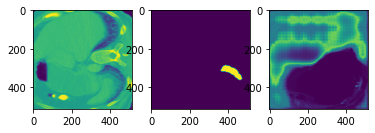

Epoch [5/100]   Batch 500   Loss: 0.6939    Max: 0.0000


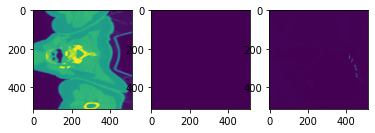

Epoch [5/100]   Batch 600   Loss: 0.6439    Max: 0.0000


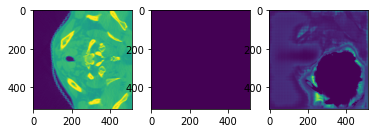

Epoch [5/100]   Batch 700   Loss: 0.6019    Max: 0.0000


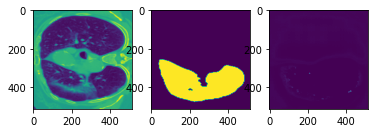

Epoch [5/100]   Batch 800   Loss: 0.7019    Max: 0.0000


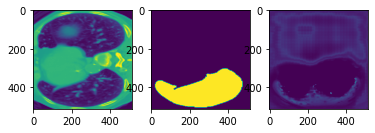

Epoch [5/100]   Batch 900   Loss: 0.6059    Max: 0.0000


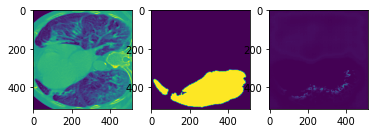

Epoch [5/100]   Batch 1000   Loss: 0.6839    Max: 0.0000


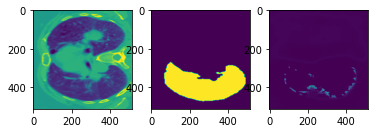

Epoch [5/100]   Batch 1100   Loss: 0.6519    Max: 0.0000


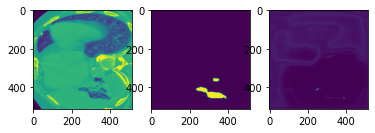

Epoch [5/100]   Batch 1200   Loss: 0.7278    Max: 0.0000


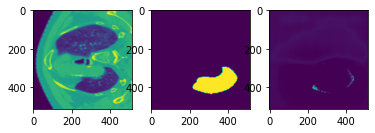

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


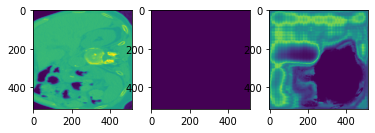

Epoch [6/100]   Batch 200   Loss: 0.5099    Max: 0.0000


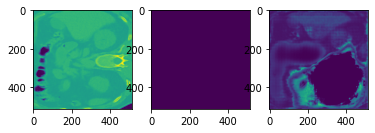

Epoch [6/100]   Batch 300   Loss: 0.7559    Max: 0.0000


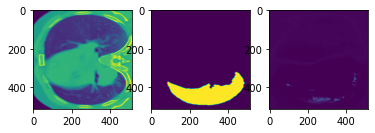

Epoch [6/100]   Batch 400   Loss: 0.7399    Max: 0.0000


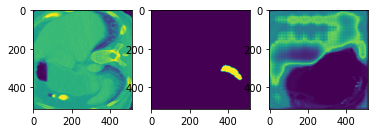

Epoch [6/100]   Batch 500   Loss: 0.6939    Max: 0.0000


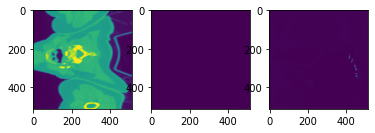

Epoch [6/100]   Batch 600   Loss: 0.6439    Max: 0.0000


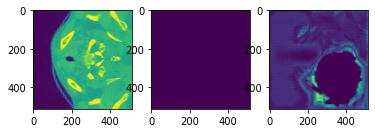

Epoch [6/100]   Batch 700   Loss: 0.6019    Max: 0.0000


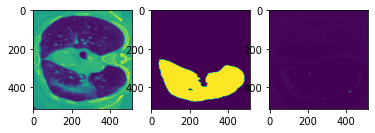

Epoch [6/100]   Batch 800   Loss: 0.7019    Max: 0.0000


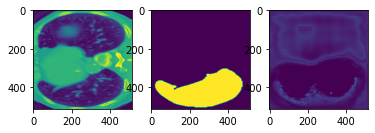

Epoch [6/100]   Batch 900   Loss: 0.6059    Max: 0.0000


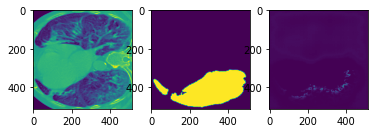

Epoch [6/100]   Batch 1000   Loss: 0.6839    Max: 0.0000


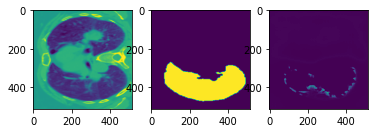

Epoch [6/100]   Batch 1100   Loss: 0.6519    Max: 0.0000


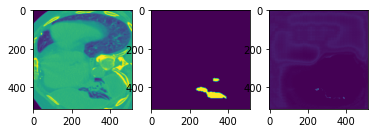

Epoch [6/100]   Batch 1200   Loss: 0.7278    Max: 0.0000


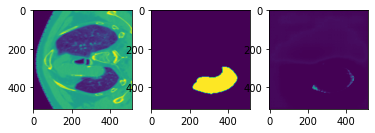

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


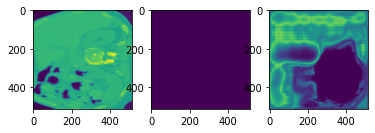

Epoch [7/100]   Batch 200   Loss: 0.5099    Max: 0.0000


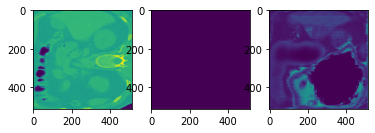

Epoch [7/100]   Batch 300   Loss: 0.7559    Max: 0.0000


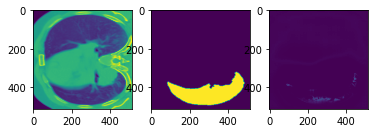

Epoch [7/100]   Batch 400   Loss: 0.7399    Max: 0.0000


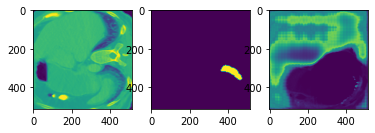

Epoch [7/100]   Batch 500   Loss: 0.6939    Max: 0.0000


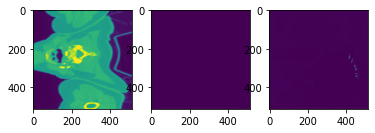

Epoch [7/100]   Batch 600   Loss: 0.6439    Max: 0.0000


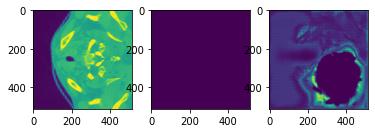

Epoch [7/100]   Batch 700   Loss: 0.6019    Max: 0.0000


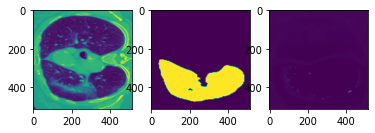

Epoch [7/100]   Batch 800   Loss: 0.7019    Max: 0.0000


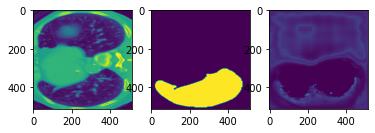

Epoch [7/100]   Batch 900   Loss: 0.6059    Max: 0.0000


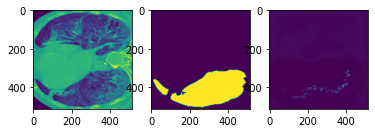

Epoch [7/100]   Batch 1000   Loss: 0.6839    Max: 0.0000


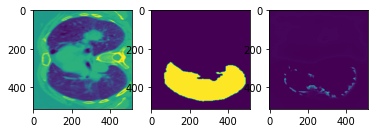

Epoch [7/100]   Batch 1100   Loss: 0.6519    Max: 0.0000


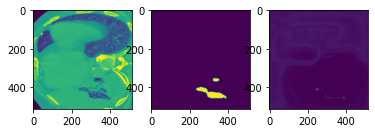

Epoch [7/100]   Batch 1200   Loss: 0.7278    Max: 0.0000


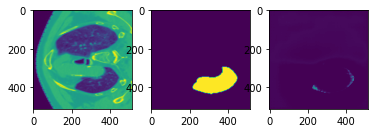

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


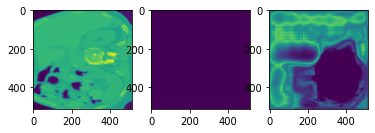

Epoch [8/100]   Batch 200   Loss: 0.5099    Max: 0.0000


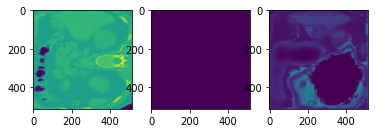

KeyboardInterrupt: 

In [53]:
print("Starting LR: ",0.01)
print('\n')

fit(model=model, img_size=img_size, seg_organ=seg_organ, window_size=window_size,
    loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler,
    epochs=epochs, train_df=train_df, test_df=test_df, 
    validate=True, print_every=100)

In [49]:
eval(model=model,test_df=test_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size)

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


KeyboardInterrupt: 

In [41]:
#torch.save(model.state_dict(),'Adv_MSA_wAG_Model/v1' )
#'/content/drive/MyDrive/AI Club Project - Segmentation/UNet - Models/Single Slice Models/adv_sma_wag_lung_l_100epochs'